In [32]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
from scipy.linalg import solve, pinv
import matplotlib.pyplot as plt

In [33]:
def dxdt_lorenz(x,time,r_t, sigma = 10., beta = 8/3, rho = 28.):
    return np.array([sigma*(- x[0] + x[1]),\
                     r_t(time)*rho*x[0] - x[1] - x[0]*x[2],\
                     x[0]*x[1]-beta*x[2]])
    
def rk4(x, time, tau, r_t, dxdt):
    k1 = dxdt(x, time, r_t)
    k2 = dxdt(x + k1/2*tau, time + tau/2, r_t)
    k3 = dxdt(x + k2/2*tau, time + tau/2, r_t)
    k4 = dxdt(x + tau*k3, time + tau, r_t)
    
    xnext = x + 1/6*tau*(k1+2*k2+2*k3+k4)
    return xnext

def getLorenzData(data_length, r_t, dxdt_lorenz,transient_length = 1000, tau = 0.1):
    x = np.random.rand(3)
    time = -transient_length*tau
    for i in range(0,transient_length):
        x = rk4(x,time,tau,r_t,dxdt_lorenz)
        time += tau
    
    data = np.zeros((3,data_length))
    data[:,0] = x
    for i in range(0,data_length-1):
        data[:,i+1] = rk4(data[:,i],time,tau,r_t,dxdt_lorenz)
        time += tau
        
    return data

def r_t_cosine(time, period = 500, max_height = 48/28):
    r = 1 + (max_height-1.)/2 - (max_height-1)/2*np.cos(2*np.pi/period*time)
    return r

def r_t_const(time, value = 1):
    # Function for constant rho value
    r = value
    return r

def advanceReservoir(win,A_mat,x,u,leakage):
    x_next = leakage*x + (1-leakage)*np.tanh(A_mat.dot(x) + np.matmul(win,u))
    return x_next

def getPrediction(win, A_mat, wout, x, predict_length, leakage):
    prediction = np.zeros((wout.shape[0],predict_length))
    aug_x = np.copy(x)
    aug_x[::2] = np.power(x[::2],2)
    prediction[:,0] = np.matmul(wout,aug_x)
    
    for pred_idx in range(0,predict_length - 1):
        x = advanceReservoir(win, A_mat, x, prediction[:,pred_idx], leakage)
        aug_x = np.copy(x)
        aug_x[::2] = np.power(x[::2],2)
        prediction[:,pred_idx + 1] = np.matmul(wout,aug_x)
        
    return prediction

In [34]:
input_weight = 1e-2
spectral_radius = 0.9
regularization = 1e-4
average_degree = 3
leakage = 0
forget = 1
inv_forget = 1/forget
data_seed = 30

step = 0.05
transient_length = int(50/step)
data_length = int(3000/step)
train_length = int(200/step)
start_length = int(50/step)
predict_length = int(20/step)
predict_gap_length = int(5/step)
num_predictions = 100

approx_num_nodes = 300
np.random.seed(data_seed)
train_input_sequence = getLorenzData(data_length,r_t_cosine,dxdt_lorenz,tau = 0.05)

In [35]:
input_size = train_input_sequence.shape[0]
num_nodes = int(np.ceil(approx_num_nodes/input_size)*input_size);

A_mat = sparse.random(num_nodes,num_nodes, density = average_degree/num_nodes)
eg = linalg.eigs(A_mat, k = 1, return_eigenvectors=False)
A_mat = spectral_radius/np.abs(eg[0])*A_mat

q = int(np.floor(num_nodes/(input_size)))
win = np.zeros((num_nodes,input_size))
for i in range(input_size):
    np.random.seed(i)
    ip = (-1 + 2*np.random.randn(q));
    win[i*q:(i+1)*q,i] = input_weight*ip;
    
x = np.zeros(num_nodes)
states = np.zeros((num_nodes, start_length))

In [36]:
for t in range(transient_length):
    x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)
    
states[:,0] = x;

for t in range(start_length-1):
    states[:,t+1] = advanceReservoir(win,A_mat,states[:,t],train_input_sequence[:,t+transient_length],leakage)
    
x = states[:,-1]
    
aug_states = np.copy(states)
aug_states[::2,:] = np.power(states[::2,:],2)
idenmat = regularization*sparse.identity(num_nodes)
s_mat = np.diag(np.power(forget,np.arange(start_length)[::-1]))
data_trstates = np.matmul(np.matmul(train_input_sequence[:,transient_length:transient_length+start_length],\
                                    s_mat),\
                          np.transpose(aug_states))
states_trstates = np.matmul(np.matmul(aug_states,s_mat),np.transpose(aug_states))
states_trstates_inv = pinv(states_trstates + idenmat)
wout = np.matmul(data_trstates,states_trstates_inv)

wout_norm = np.copy(wout)
x_norm = np.copy(x)

In [37]:
error_cutoff = 1;
predictions = np.zeros((input_size,predict_length,num_predictions))
errors = np.zeros((predict_length,num_predictions))
valid_times = np.zeros(num_predictions)
wouts = np.zeros((input_size,num_nodes,num_predictions))
for pred in range(num_predictions):
    wouts[:,:,pred] = wout
    predictions[:,:,pred] = getPrediction(win,A_mat,wout,x,predict_length,leakage)
    start_pred_idx = transient_length + start_length + pred*predict_gap_length - 1
    truth = train_input_sequence[:,start_pred_idx :start_pred_idx + predict_length]
    errors[:,pred] = np.linalg.norm(predictions[:,:,pred] - truth, axis = 0)/np.sqrt(np.mean(truth**2))
    
    for i in range(predict_length):
        if errors[i,pred] > error_cutoff:
            break
        else:
            valid_times[pred] += 1
            
    for i in range(predict_gap_length):
        x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
        aug_x = np.copy(x)
        aug_x[::2] = np.power(x[::2],2)
        data_trstates = forget*data_trstates + np.outer(train_input_sequence[:,start_pred_idx + i + 1],aug_x)
        
        states_trstates_inv = inv_forget*(states_trstates_inv - 1.0/\
                                          (1+inv_forget*np.dot(np.dot(aug_x,states_trstates_inv),aug_x))*\
                                          np.outer(np.dot(states_trstates_inv,aug_x),np.dot(aug_x,states_trstates_inv))\
                                          *inv_forget)
        
    wout = np.matmul(data_trstates,states_trstates_inv)
    
    
print(valid_times)

[45. 22. 50. 62. 39. 19. 63. 51. 36. 55. 52. 40. 39. 34. 17. 42. 46. 59.
 38. 31. 31. 44. 43. 58. 11. 77. 51. 64. 10. 64. 36. 21. 50. 42. 38. 54.
 52. 48. 28. 48. 71. 44. 87. 35. 81. 53. 56. 73. 72. 23. 20. 14. 12. 12.
 19. 17. 23. 10. 11. 14.  9.  8. 14. 25.  8. 27. 15. 28. 10. 11. 12.  7.
  7.  7. 11. 14.  8. 11.  8.  8. 11.  8. 14.  8. 10.  9. 13.  7. 10. 13.
 25. 23. 14. 19. 19. 19. 22. 37. 17. 12.]


In [ ]:
predictions_norm = np.zeros((input_size,predict_length,num_predictions))
errors_norm = np.zeros((predict_length,num_predictions))
valid_times_norm = np.zeros(num_predictions)
wouts_norm = np.zeros((input_size,num_nodes,num_predictions))


for pred in range(num_predictions):
    wouts_norm[:,:,pred] = wout_norm
    predictions_norm[:,:,pred] = getPrediction(win,A_mat,wout_norm,x_norm,predict_length,leakage)
    start_pred_idx = transient_length + start_length + pred*predict_gap_length - 1
    truth = train_input_sequence[:,start_pred_idx:start_pred_idx + predict_length]
    errors_norm[:,pred] = np.linalg.norm(predictions_norm[:,:,pred] - truth, axis = 0)/np.sqrt(np.mean(truth**2))
    
    for i in range(predict_length):
        if errors_norm[i,pred] > error_cutoff:
            break
        else:
            valid_times_norm[pred] += 1
            
    new_states = np.zeros((num_nodes,predict_gap_length))
    for i in range(predict_gap_length):
        x_norm = advanceReservoir(win,A_mat,x_norm,train_input_sequence[:,start_pred_idx + i],leakage)
        new_states[:,i] = x_norm
    
    new_aug_states = np.copy(new_states)
    new_aug_states[::2,:] = np.power(new_states[::2,:],2)
    aug_states = np.concatenate((aug_states,new_aug_states),axis = 1)
    s_mat = np.diag(np.power(forget,np.arange(aug_states.shape[1])[::-1]))
    data_trstates = np.matmul(np.matmul(train_input_sequence[:,\
                                                             transient_length:start_pred_idx + predict_gap_length + 1],\
                                    s_mat),\
                          np.transpose(aug_states))
    states_trstates = np.matmul(np.matmul(aug_states,s_mat),np.transpose(aug_states))
        
    wout_norm = np.transpose(solve(np.transpose(states_trstates + idenmat),np.transpose(data_trstates)))
    
    
print(valid_times_norm)

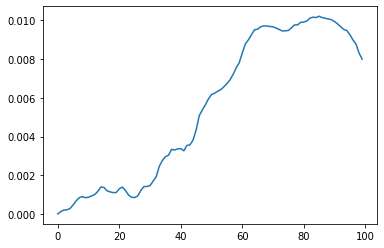

In [28]:
wouts_abs = np.sqrt(np.mean((wouts - wouts_norm)**2,axis = (0,1)))
plt.plot(wouts_abs)
plt.show()

In [ ]:
times = step*(transient_length + start_length + np.arange(num_predictions)*predict_gap_length)
plt.plot(times,r_t_cosine(times))
plt.show()
plt.plot(predictions[1,:,0])
plt.plot(predictions[1,:,50])
plt.show